## 0. Loading Packages

In [18]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp
import git
from pathlib import Path
import warnings
import os
import matplotlib.pyplot as plt
import seaborn as sns
ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from transform_audio import *
warnings.filterwarnings("ignore", category=UserWarning, module='numpy.lib.npyio')

## 1. Select transform type and group

In [19]:
groups = {3: ['normal_intensity', 'strong_intensity'], 4: ['statement_1', 'statement_2'], 6: ['male', 'female']}
group = 6
categories = {3: 'emotional intensity', 4: 'statement', 6: 'gender'}

CATEGORY_NAME = categories[group]
GROUP_NAMES = groups[group]

# Suffix used to construct internal filenames
transform_affix = 'erb'

KS_THRESHOLD = 0.05  

# --- Path Definitions ---
DATA_DIR = os.path.join(ROOT_DIR, 'raw-data', 'ravdess', 'ravdess-transforms')
PATHS = {
    "Original-Pitch": {
        "coefs_path": os.path.join(DATA_DIR, f'{transform_affix}_coefs.npz'),
        "freqs_path": os.path.join(DATA_DIR, f'{transform_affix}_freqs.npy')
    },
    "Pitch-Normalized": {
        "coefs_path": os.path.join(DATA_DIR, f'{transform_affix}-pn_coefs.npz'),
        "freqs_path": os.path.join(DATA_DIR, f'{transform_affix}-pn_freqs.npy')
    }
}

print("✅ Loaded successfully.")
print(f"Analysis Category: {CATEGORY_NAME.replace('_', ' ').title()} ({GROUP_NAMES[0]} vs {GROUP_NAMES[1]})")
print(f"KS Test Decision Threshold: {KS_THRESHOLD}")

✅ Loaded successfully.
Analysis Category: Gender (male vs female)
KS Test Decision Threshold: 0.05


## 2. Analysis Functions

In [ ]:
def load_and_combine_data(coefs_npz_path, group_id, group_map, category_map):
    """
    Loads an NPZ file and merges all internal .npy coefficient files into a single
    DataFrame. This definitive version handles 1D (FFT), 2D (STFT), and 
    jagged object arrays (Erblet).
    """
    print(f"  - Loading and combining data from: {os.path.basename(coefs_npz_path)}")
    category_name = category_map[group_id]
    group_names = group_map[group_id]
    
    all_coeffs_data = []
    # Use allow_pickle=True to handle object arrays
    with np.load(coefs_npz_path, allow_pickle=True) as data:
        for item in data.files:
            try:
                base_filename = item.split('_')[0]
                actor_id = int(base_filename.split('-')[group_id])
                group_label = group_names[1] if actor_id % 2 == 0 else group_names[0]
                
                coeffs = data[item]
                
                if coeffs.ndim == 2:
                    for freq_idx in range(coeffs.shape[0]):
                        for coeff_val in coeffs[freq_idx, :]:
                            all_coeffs_data.append({
                                category_name: group_label, 'freq_index': freq_idx,
                                'coefficient_real': np.real(coeff_val), 'coefficient_imag': np.imag(coeff_val)
                            })
                
                elif coeffs.ndim == 1:
                    if coeffs.dtype == object: 
                        for freq_idx, inner_array in enumerate(coeffs):
                            # Check if the element is actually an iterable array
                            if hasattr(inner_array, '__iter__'):
                                for coeff_val in inner_array:
                                    all_coeffs_data.append({
                                        category_name: group_label, 'freq_index': freq_idx,
                                        'coefficient_real': np.real(coeff_val), 'coefficient_imag': np.imag(coeff_val)
                                    })
                            else: # Failsafe for single numbers within the object array
                                all_coeffs_data.append({
                                    category_name: group_label, 'freq_index': freq_idx,
                                    'coefficient_real': np.real(inner_array), 'coefficient_imag': np.imag(inner_array)
                                })
                    else:
                        for freq_idx, coeff_val in enumerate(coeffs):
                            all_coeffs_data.append({
                                category_name: group_label, 'freq_index': freq_idx,
                                'coefficient_real': np.real(coeff_val), 'coefficient_imag': np.imag(coeff_val)
                            })
                else:
                    print(f"  - Warning: Skipping item '{item}' with unsupported shape {coeffs.shape}")
                    continue

            except (ValueError, IndexError) as e:
                print(f"  - Warning: Could not parse filename '{item}', skipped. Error: {e}")
                continue
                
    if not all_coeffs_data:
        print("❗️Warning: Could not load any coefficient data from NPZ file. Please check file formats and group_id.")

    return pd.DataFrame(all_coeffs_data)

def compare_distributions_by_band(full_df, unified_bands_indices, category_name, group_names):
    """
    Compares the coefficient distributions of two groups band by band under a unified banding scheme.
    """
    if category_name not in full_df.columns:
        raise KeyError(f"Error: Column '{category_name}' not found in DataFrame. Please check the load_and_combine_data function.")

    print(f"  - Performing KS test band by band ({group_names[0]} vs {group_names[1]})...")

    group1_df = full_df[full_df[category_name] == group_names[0]]
    group2_df = full_df[full_df[category_name] == group_names[1]]
    
    results = []
    for start_idx, end_idx in unified_bands_indices:
        group1_in_band = group1_df[(group1_df['freq_index'] >= start_idx) & (group1_df['freq_index'] < end_idx)]
        group2_in_band = group2_df[(group2_df['freq_index'] >= start_idx) & (group2_df['freq_index'] < end_idx)]
        
        if len(group1_in_band) < 30 or len(group2_in_band) < 30: continue

        ks_stat_real, _ = ks_2samp(group1_in_band['coefficient_real'], group2_in_band['coefficient_real'])
        ks_stat_imag, _ = ks_2samp(group1_in_band['coefficient_imag'], group2_in_band['coefficient_imag'])
        
        results.append({
            'band_indices': f'{start_idx}-{end_idx - 1}' if end_idx > start_idx + 1 else str(start_idx),
            'ks_stat_real': ks_stat_real,
            'ks_stat_imag': ks_stat_imag,
        })
            
    return pd.DataFrame(results)

## 3. Distribution Analysis

In [21]:
all_results = {}
all_files_exist = True

for experiment_name, paths in PATHS.items():
    print(f"\n{'='*20} Starting Experiment: {experiment_name} {'='*20}")
    
    # Check if files exist
    if not os.path.exists(paths["coefs_path"]) or not os.path.exists(paths["freqs_path"]):
        print(f"❗️Error: Cannot find file {paths['coefs_path']} or {paths['freqs_path']}.")
        all_files_exist = False
        break

    print("  - Counting files per group...")
    try:
        with np.load(paths["coefs_path"]) as data:
            # Initialize a dictionary to hold the counts
            file_counts = {name: 0 for name in GROUP_NAMES}
            
            # Iterate through all the .npy files within the .npz archive
            for item in data.files:
                try:
                    base_filename = item.split('_')[0]
                    actor_id = int(base_filename.split('-')[group])
                    group_label = GROUP_NAMES[1] if actor_id % 2 == 0 else GROUP_NAMES[0]
                    file_counts[group_label] += 1
                except (ValueError, IndexError):
                    # This handles cases where a filename doesn't match the expected format
                    continue
        
        # Print the summary of file counts
        for group_name, count in file_counts.items():
            print(f"    - Found {count} files for '{group_name.title()}'")
    except Exception as e:
        print(f"  - ❗️Could not count files due to an error: {e}")

    # Step 1: Calculate unified frequency bands on the combined dataset
    print("  - Calculating unified frequency bands...")
    unified_band_indices = freq_band_groupings(
        coefs_npz_path=paths["coefs_path"],
        freqs_npy_path=paths["freqs_path"],
        ks_threshold=KS_THRESHOLD,
        presplit_depth=1
    )
    print(f"  - Unified banding complete. Found {len(unified_band_indices)} bands.")
    
    # Step 2: Load the data into a single DataFrame
    full_df = load_and_combine_data(paths["coefs_path"], group, groups, categories)

    # Step 3: Compare distributions within the unified bands
    if not full_df.empty:
        comparison_df = compare_distributions_by_band(full_df, unified_band_indices, CATEGORY_NAME, GROUP_NAMES)
        all_results[experiment_name] = comparison_df
    else:
        all_results[experiment_name] = pd.DataFrame()

    print(f"✅ Experiment {experiment_name} complete.")


==================== Starting Experiment: Original-Pitch ====================
  - Counting files per group...
    - Found 720 files for 'Male'
    - Found 720 files for 'Female'
  - Calculating unified frequency bands...
  - Unified banding complete. Found 18 bands.
  - Loading and combining data from: erb_coefs.npz
  - Performing KS test band by band (male vs female)...
✅ Experiment Original-Pitch complete.

==================== Starting Experiment: Pitch-Normalized ====================
  - Counting files per group...
    - Found 720 files for 'Male'
    - Found 720 files for 'Female'
  - Calculating unified frequency bands...
  - Unified banding complete. Found 20 bands.
  - Loading and combining data from: erb-pn_coefs.npz
  - Performing KS test band by band (male vs female)...
✅ Experiment Pitch-Normalized complete.


## 4. Results and Visualization


############################################################
### Analysis Report: Gender ###
############################################################

--- Results for: Original-Pitch (male vs female) ---
In 18 bands, 6 have a difference greater than the threshold 0.05.
band_indices  ks_stat_real  ks_stat_imag
           0         0.162         0.109
           1         0.070         0.057
           2         0.062         0.064
           3         0.172         0.176
           4         0.241         0.241
        5-10         0.072         0.073
       11-12         0.011         0.011
       13-15         0.023         0.023
       16-21         0.015         0.015
       22-26         0.011         0.011
       27-29         0.034         0.035
       30-32         0.015         0.014
       33-38         0.026         0.026
          39         0.026         0.026
       40-41         0.031         0.031
          42         0.029         0.030
          43         0.019  

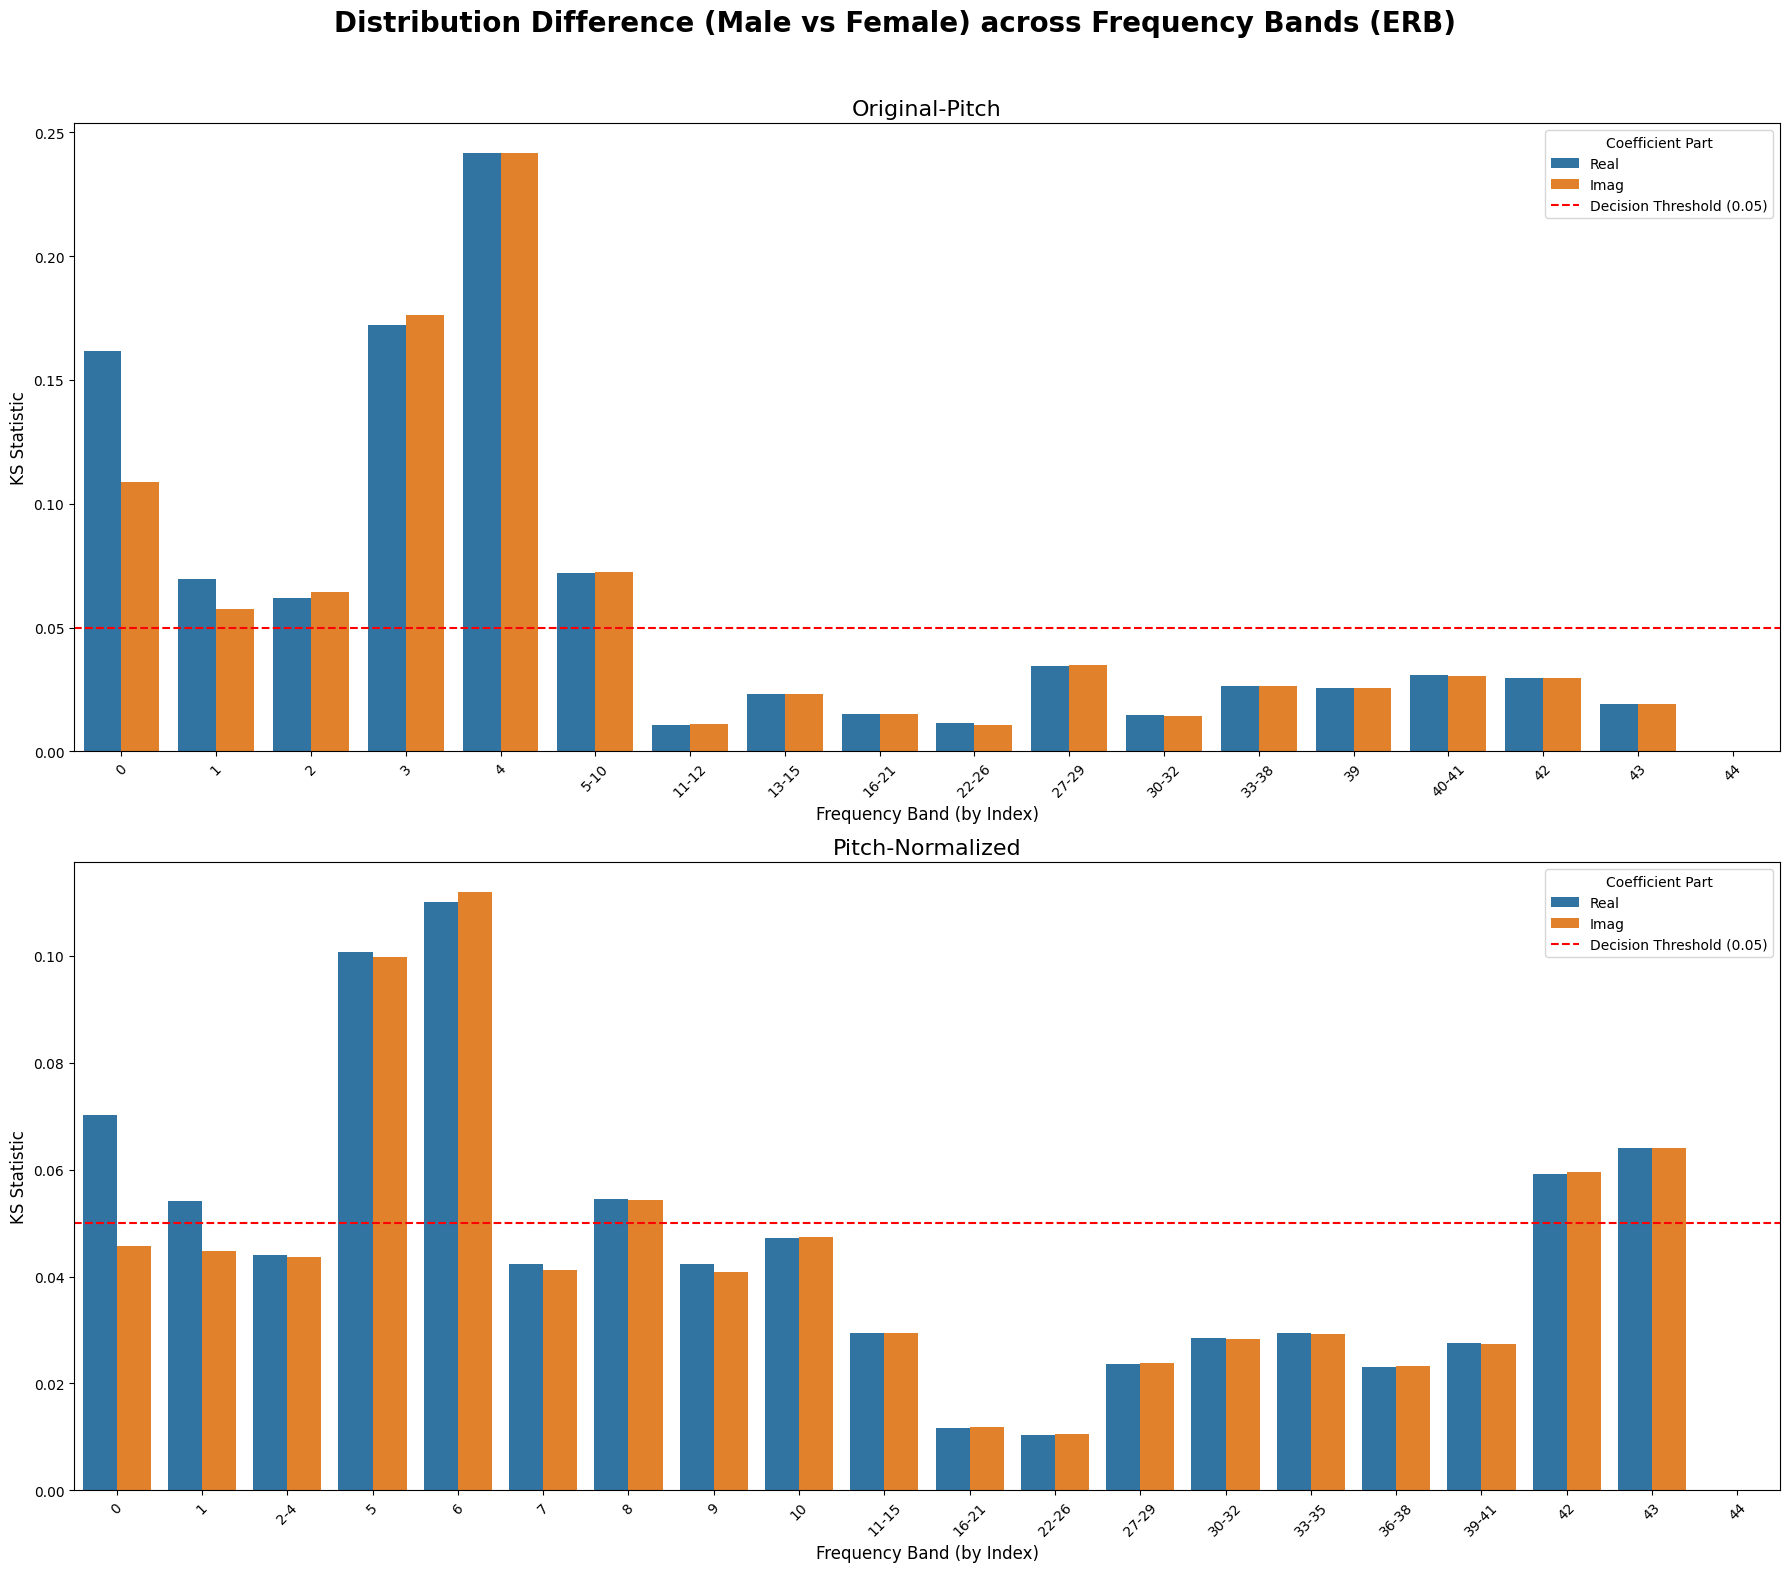

In [22]:
if not all_files_exist:
    print("\n❗️Analysis could not be completed due to missing files. Cannot generate report.")
else:
    print("\n" + "#"*60)
    print(f"### Analysis Report: {CATEGORY_NAME.replace('_', ' ').title()} ###")
    print("#"*60 + "\n")
    
    for experiment_name, result_df in all_results.items():
        print(f"--- Results for: {experiment_name} ({GROUP_NAMES[0]} vs {GROUP_NAMES[1]}) ---")
        if result_df.empty:
            print("  - No results to display for this experiment.")
            continue
        
        significant_diffs = result_df[
            (result_df['ks_stat_real'] > KS_THRESHOLD) | 
            (result_df['ks_stat_imag'] > KS_THRESHOLD)
        ]
        print(f"In {len(result_df)} bands, {len(significant_diffs)} have a difference greater than the threshold {KS_THRESHOLD}.")
        print(result_df.round(3).to_string(index=False))
        print("\n")

    # --- Visualization ---
    fig, axes = plt.subplots(len(all_results), 1, figsize=(18, 8 * len(all_results)), sharex=False)
    if len(all_results) == 1: axes = [axes]
    fig.suptitle(f'Distribution Difference ({GROUP_NAMES[0].title()} vs {GROUP_NAMES[1].title()}) across Frequency Bands ({transform_affix.upper()})', fontsize=20, weight='bold')

    for ax, (experiment_name, result_df) in zip(axes, all_results.items()):
        if result_df.empty:
            ax.text(0.5, 0.5, 'No data to plot for this experiment.', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            ax.set_title(experiment_name, fontsize=16)
            continue
        
        plot_df = result_df.melt(
            id_vars=['band_indices'], 
            value_vars=['ks_stat_real', 'ks_stat_imag'],
            var_name='Coefficient Part',
            value_name='KS Statistic'
        )
        plot_df['Coefficient Part'] = plot_df['Coefficient Part'].str.replace('ks_stat_', '').str.title()
        
        # Create the bar plot
        sns.barplot(ax=ax, data=plot_df, x='band_indices', y='KS Statistic', hue='Coefficient Part')
        
        # Add the decision threshold line
        ax.axhline(y=KS_THRESHOLD, color='r', linestyle='--', label=f'Decision Threshold ({KS_THRESHOLD})')
        
        ax.set_title(experiment_name, fontsize=16)
        ax.set_xlabel('Frequency Band (by Index)', fontsize=12)
        ax.set_ylabel('KS Statistic', fontsize=12)
        ax.tick_params(axis='x', rotation=45)
        ax.legend(title='Coefficient Part')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
